# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./models/')

from cond_CFM import CNF

import numpy as np
import os
from tqdm import tqdm
from typing import *
from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout

from matplotlib import pyplot as plt

from jet_dataset import JetDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
save_dir_CFM = './data/CFM_jets6/'
path_add_AdamMCMC = '/AdamMCMC_models_lambda50/'
m_list_dir = save_dir_CFM + path_add_AdamMCMC

save_dir_BBB_CFM = './data/CFM_VIB_sampling_corrected_k100_jets6/'

In [4]:
#######################
### Define the data ###
#######################

dont_use = ['jet_sdmass', 
            'jet_tau1',	'jet_tau2',	'jet_tau3',	'jet_tau4',
            'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']

dataset = JetDataset("./jet_data",'train', del_context=dont_use)
dataset_val = JetDataset("./jet_data",'val', del_context=dont_use)

In [5]:
########################
### Define the Model ###
########################

model_AdamMCMC = CNF(1, conds = dataset.features.shape[1], n_nodes=[64] * 3).to(device)

model_VIB = CNF(1, conds = dataset.features.shape[1], n_nodes=[64] * 3, layer = LinearFlipout).to(device)
model_VIB.load_state_dict(torch.load(save_dir_BBB_CFM + f"model_4000.pth"))

for layer in model_VIB.modules():
    if isinstance(layer, LinearFlipout):
        layer._dnn_to_bnn_flag = True

In [6]:
color_target = 'red'
color_AdamMCMC = 'coral'
color_VIB = 'darkblue'

colors = [color_AdamMCMC, color_VIB]
labels = ['AdamMCMC-CFM', 'VIB-CFM']

sort = np.argsort(dataset_val.features[:,1])
bins = np.linspace(0,1,21)

In [17]:
m_list = [l for l in os.listdir(m_list_dir) if 'model' in l]
n_stat = len(m_list)+1
n_stat_alea = 50000

for event in [200003, -100005, -10000, 'pt', 'E', 'n']:
    if isinstance(event, str):
        k = -10000
    else:
        k = event
    fig,ax = plt.subplots(1,1, figsize = (8,4), sharex = True)#gridspec_kw={'height_ratios': [2,1], 'hspace': 0.})
    ax = [ax]
    i = sort[k]
    conditions = torch.Tensor(dataset_val.features).to(device)
    c = conditions[i:i+1]

    if event == 'pt':
        c[:,1] = (c[:,1]*dataset_val.std_norm[0,1]+500)/dataset_val.std_norm[0,1]
        
    elif event == 'E':
        c[:,4] = (c[:,4]*dataset_val.std_norm[0,4]+3500)/dataset_val.std_norm[0,4]

    elif event == 'n':
        c[:,5] = (c[:,5]*dataset_val.std_norm[0,5]+100)/dataset_val.std_norm[0,5]


    z = torch.randn(n_stat_alea, 1).to(device)

    for j,model in enumerate([model_AdamMCMC, model_VIB]):
        
        hists = []
        x_gens = []
        for n in tqdm(range(n_stat)):
            if j == 0:
                if n==0:
                    model.load_state_dict(torch.load(save_dir_CFM + f"model_4000.pth"))
                else:
                    model.load_state_dict(torch.load(m_list_dir + m_list[n-1]))
                    #print('loaded model from ' + m_list_dir + m_list[n-1])
            else:
                for layer in model.modules():
                    if isinstance(layer, LinearFlipout):
                        layer.auto_sample = False 
                        layer.sample_weights()

            x_gen = model.decode(z, cond=c.repeat_interleave(n_stat_alea, dim=0))
            
            x_gen = torch.sigmoid(x_gen*20).detach().cpu().numpy()
            #x_gen = (x_gen*20).detach().cpu().numpy()
            x_gens.append(x_gen)
            hist, _ = np.histogram(x_gen, bins = bins)
            hists.append(hist)
        
        x_gens = np.array(x_gens)
        hists = np.array(hists)
        hist_max = hists.max(0)
        hist_min = hists.min(0)

        #if j == 0:
        #    hist_orig,b,_ = ax[0].hist(x_gens[0],  bins = bins, edgecolor=colors[i], facecolor = None, fill=False, hatch = '/////')
        #else:
        hist_orig,b,_ = ax[0].hist(x_gens[0],  bins = bins, color=colors[j], alpha=0.2)

        bincentres = [(b[i]+b[i+1])/2. for i in range(len(b)-1)]
        ax[0].step(bincentres, hist_max, where='mid',color=colors[j], label=labels[j])
        ax[0].step(bincentres, hist_min, where='mid',color=colors[j])

    lower_limit = ax[0].get_ylim()[0]
    upper_limit = 3*ax[0].get_ylim()[1]  
    if not isinstance(event, str):
        x_value = torch.sigmoid(torch.Tensor(dataset_val.target)[i,0]*20).numpy()
        ax[0].vlines(x_value, lower_limit, upper_limit, color = color_target)
        ax[0].text(x_value-0.01, 0.7*upper_limit, 'ParT', {'color': color_target, 'ha': 'right', 'va': 'top'})

    #alpha = 0.95
    #quants = np.quantile(x_gens, 1-alpha, axis=1)
    #ax[0].vlines(np.quantile(x_gens.mean(0), 1-alpha), *ax[0].get_ylim(), color = 'red')
    #ax[0].vlines([quants.max(0), quants.min(0)], *ax[0].get_ylim(), color = 'red', linestyle='--')

    ax[0].set_ylabel('occurence')
   #ax[0].set_xlabel(r'$\mathrm{sig}^{-1}$ (ParT/B-CFM output)')
    ax[0].set_xlabel('ParT/B-CFM output')
    ax[0].set_yscale('log')
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(None, upper_limit)
    ax[0].legend()

    out_pt = c[0,1]*dataset_val.std_norm[0,1]+dataset_val.means_norm[0,1]
    fig.suptitle(r'$p_T =$' + f'{out_pt:4.1f} GeV')
    plt.savefig(f'./figs/compare_out_{i}_{event}_hmc.pdf')
    plt.show()

  0%|          | 0/112 [00:00<?, ?it/s]

  6%|▋         | 7/112 [00:02<00:33,  3.10it/s]

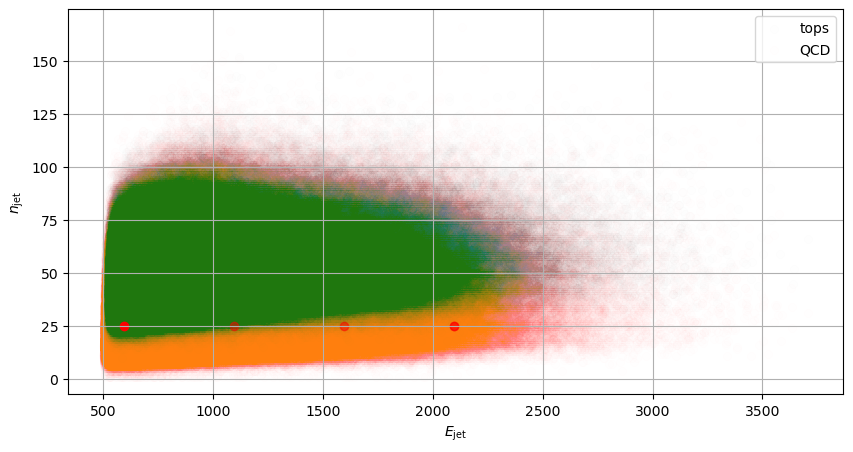

In [7]:
p = 2073
mask = dataset.features[:,0]==1.


plt.figure(figsize=(10,5))
plt.grid()
plt.scatter(dataset.features[mask][:,4]*dataset.std_norm[0,4]+dataset.means_norm[0,4], 
            dataset.features[mask][:,5]*dataset.std_norm[0,5]+dataset.means_norm[0,5], 
            alpha=0.005,
            label = 'tops',
            color = 'C0')
plt.scatter(dataset.features[mask==0][:,4]*dataset.std_norm[0,4]+dataset.means_norm[0,4], 
            dataset.features[mask==0][:,5]*dataset.std_norm[0,5]+dataset.means_norm[0,5], 
            alpha=0.005,
            label = 'QCD',
            color = 'C1')
plt.scatter(dataset_val.features[p, 4]*dataset_val.std_norm[0,4]+dataset_val.means_norm[0,4],
            dataset_val.features[p, 5]*dataset_val.std_norm[0,5]+dataset_val.means_norm[0,5],
            color = color_target)
plt.scatter(dataset_val.features[p, 4]*dataset_val.std_norm[0,4]+dataset_val.means_norm[0,4]+500,
            dataset_val.features[p, 5]*dataset_val.std_norm[0,5]+dataset_val.means_norm[0,5],
            alpha = 0.5,
            color = color_target)
plt.scatter(dataset_val.features[p, 4]*dataset_val.std_norm[0,4]+dataset_val.means_norm[0,4]+1000,
            dataset_val.features[p, 5]*dataset_val.std_norm[0,5]+dataset_val.means_norm[0,5],
            alpha = 0.5,
            color = color_target)
plt.scatter(dataset_val.features[p, 4]*dataset_val.std_norm[0,4]+dataset_val.means_norm[0,4]+1500,
            dataset_val.features[p, 5]*dataset_val.std_norm[0,5]+dataset_val.means_norm[0,5],
            alpha = 0.5,
            color = color_target)
plt.scatter(dataset_val.features[p, 4]*dataset_val.std_norm[0,4]+dataset_val.means_norm[0,4]+1500,
            dataset_val.features[p, 5]*dataset_val.std_norm[0,5]+dataset_val.means_norm[0,5],
            alpha = 0.5,
            color = color_target)
plt.xlabel(r'$E_\mathrm{jet}$')
plt.ylabel(r'$n_\mathrm{jet}$')
plt.legend()

In [15]:
np.arange(len(dataset_val.features))[np.bitwise_and(dataset_val.features[:,5]*dataset_val.std_norm[0,5]+dataset_val.means_norm[0,5]==25., dataset_val.features[:,0]==1.)]

array([   329,   1081,   2073,   2086,   4030,   4327,   4469,  10393,
        10708,  11605,  12491,  12788,  12876,  13144,  13722,  13734,
        14754,  20674,  20804,  21630,  21796,  24020,  30340,  30836,
        32989,  33018,  33261,  33368,  33796,  40062,  40398,  40511,
        40972,  41060,  41184,  41291,  41778,  42162,  42594,  43096,
        43738,  43776,  44371,  44436,  50615,  50741,  51529,  51700,
        52411,  52601,  53037,  53833,  54959,  60136,  61994,  62450,
        62454,  62679,  64792,  64797,  70177,  70218,  70350,  71535,
        72082,  72278,  72501,  73610,  80614,  80786,  83165,  83763,
        90074,  90325,  91236,  91423,  91844,  93287,  94275,  94286,
        94780,  94886,  94937, 100153, 100346, 101001, 102178, 102668,
       102842, 103679, 104464, 104891, 111300, 111574, 111754, 112109,
       112900, 113072, 113630, 120705, 121251, 121306, 121615, 121712,
       123199, 123660, 123695, 123728, 123729, 123981, 123993, 124234,
      

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [02:06<00:00,  1.25s/it]


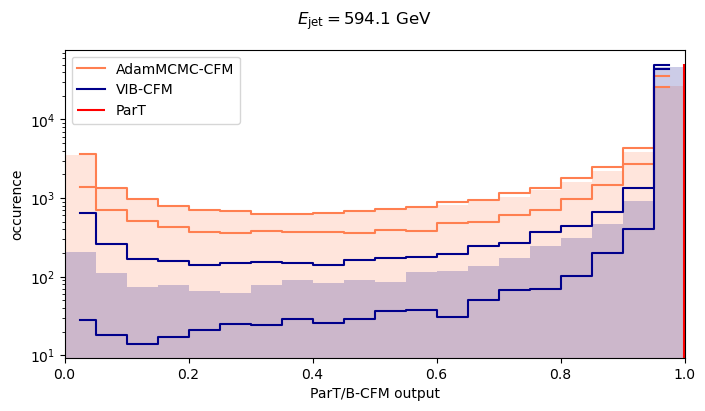

100%|██████████| 101/101 [02:17<00:00,  1.36s/it]


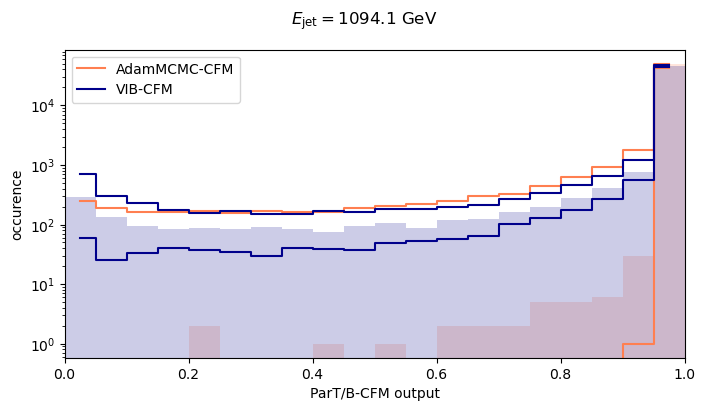

100%|██████████| 101/101 [02:13<00:00,  1.32s/it]


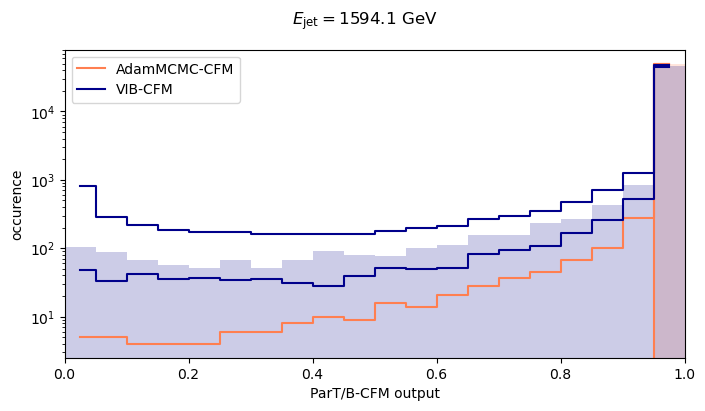

100%|██████████| 101/101 [02:12<00:00,  1.31s/it]


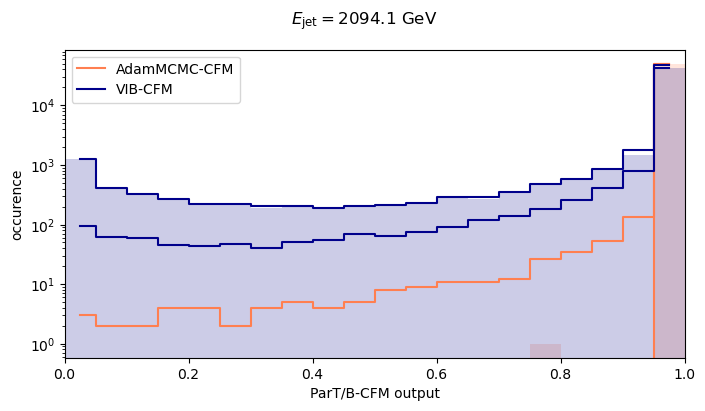

100%|██████████| 101/101 [02:19<00:00,  1.38s/it]


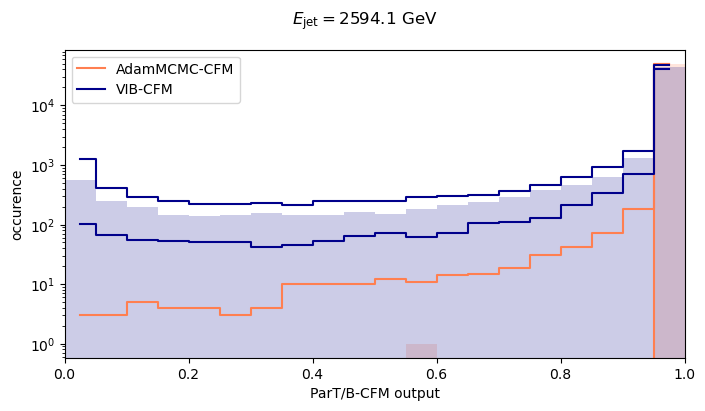

In [45]:
m_list = [l for l in os.listdir(m_list_dir) if 'model' in l]
n_stat = len(m_list)+1
n_stat_alea = 50000

for k in range(5):
    fig,ax = plt.subplots(1,1, figsize = (8,4), sharex = True)#gridspec_kw={'height_ratios': [2,1], 'hspace': 0.})
    ax = [ax]
    i = 2073
    conditions = torch.Tensor(dataset_val.features).to(device)
    c = conditions[i:i+1]
 
    c[:,4] = (c[:,4]*dataset_val.std_norm[0,4]+k*500)/dataset_val.std_norm[0,4]

    z = torch.randn(n_stat_alea, 1).to(device)

    for j,model in enumerate([model_AdamMCMC, model_VIB]):
        
        hists = []
        x_gens = []
        for n in tqdm(range(n_stat)):
            if j == 0:
                if n==0:
                    model.load_state_dict(torch.load(save_dir_CFM + f"model_4000.pth"))
                else:
                    model.load_state_dict(torch.load(m_list_dir + m_list[n-1]))
                    #print('loaded model from ' + m_list_dir + m_list[n-1])
            else:
                for layer in model.modules():
                    if isinstance(layer, LinearFlipout):
                        layer.auto_sample = False 
                        layer.sample_weights()

            x_gen = model.decode(z, cond=c.repeat_interleave(n_stat_alea, dim=0))
            
            x_gen = torch.sigmoid(x_gen*20).detach().cpu().numpy()
            #x_gen = (x_gen*20).detach().cpu().numpy()
            x_gens.append(x_gen)
            hist, _ = np.histogram(x_gen, bins = bins)
            hists.append(hist)
        
        x_gens = np.array(x_gens)
        hists = np.array(hists)
        hist_max = hists.max(0)
        hist_min = hists.min(0)

        #if j == 0:
        #    hist_orig,b,_ = ax[0].hist(x_gens[0],  bins = bins, edgecolor=colors[i], facecolor = None, fill=False, hatch = '/////')
        #else:
        hist_orig,b,_ = ax[0].hist(x_gens[0],  bins = bins, color=colors[j], alpha=0.2)

        bincentres = [(b[i]+b[i+1])/2. for i in range(len(b)-1)]
        ax[0].step(bincentres, hist_max, where='mid',color=colors[j], label=labels[j])
        ax[0].step(bincentres, hist_min, where='mid',color=colors[j])
        
    if k==0:
        ax[0].vlines(torch.sigmoid(torch.Tensor(dataset_val.target)[i,0]*20).numpy(), *ax[0].get_ylim(), color = color_target, label = 'ParT')

    #alpha = 0.95
    #quants = np.quantile(x_gens, 1-alpha, axis=1)
    #ax[0].vlines(np.quantile(x_gens.mean(0), 1-alpha), *ax[0].get_ylim(), color = 'red')
    #ax[0].vlines([quants.max(0), quants.min(0)], *ax[0].get_ylim(), color = 'red', linestyle='--')

    ax[0].set_ylabel('occurence')
   #ax[0].set_xlabel(r'$\mathrm{sig}^{-1}$ (ParT/B-CFM output)')
    ax[0].set_xlabel('ParT/B-CFM output')
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_xlim(0,1)

    out_E = c[0,4]*dataset_val.std_norm[0,4]+dataset_val.means_norm[0,4]
    fig.suptitle(r'$E_\mathrm{jet} =$' + f'{out_E:4.1f} GeV')
    plt.savefig(f'./figs/compare_out_{i}_Eplus{k*500}_hmc.pdf')
    plt.show()